<a href="https://colab.research.google.com/github/Nastarii/-Weight-Estimation-with-Anthropometrics/blob/main/Trabalho_de_Antropometria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de peso



---



## Aquisição e visualização dos Dados

In [1]:
from PIL import Image,  ImageStat, ImageChops
from imutils import face_utils
from google.colab import drive
from numpy import empty
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import imutils
import dlib
import math
import os

drive.mount('./drive')

Mounted at ./drive


In [2]:
df = pd.read_csv('./drive/MyDrive/Antropometria/final_soccer_dataset.csv',index_col= 0)

### Info

In [ ]:
print('Tamanho do banco de dados: {}'.format(len(df)))
print('Tamanho das imagens: {}'.format(Image.open(df['img_path'][0]).size))

Tamanho do banco de dados: 21233
Tamanho das imagens: (120, 120)


### Visualização do dataframe

In [ ]:
df.head(2)

,short_name,long_name,age,height_cm,weight_kg,img_url,img_path,ignore,1,2,...,127,128,129,130,131,132,133,134,135,136
0,L. Messi,Lionel Andrés Messi Cuccittini,28,170,72,https://cdn.sofifa.net/players/158/023/16_120.png,./drive/MyDrive/Antropometria/players/158/023/...,False,32,56,...,62,85,66,88,62,86,58,86,55,85
1,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,30,185,80,https://cdn.sofifa.net/players/020/801/16_120.png,./drive/MyDrive/Antropometria/players/020/801/...,False,28,58,...,61,82,69,83,61,87,57,87,54,87


### Visualização das imagens

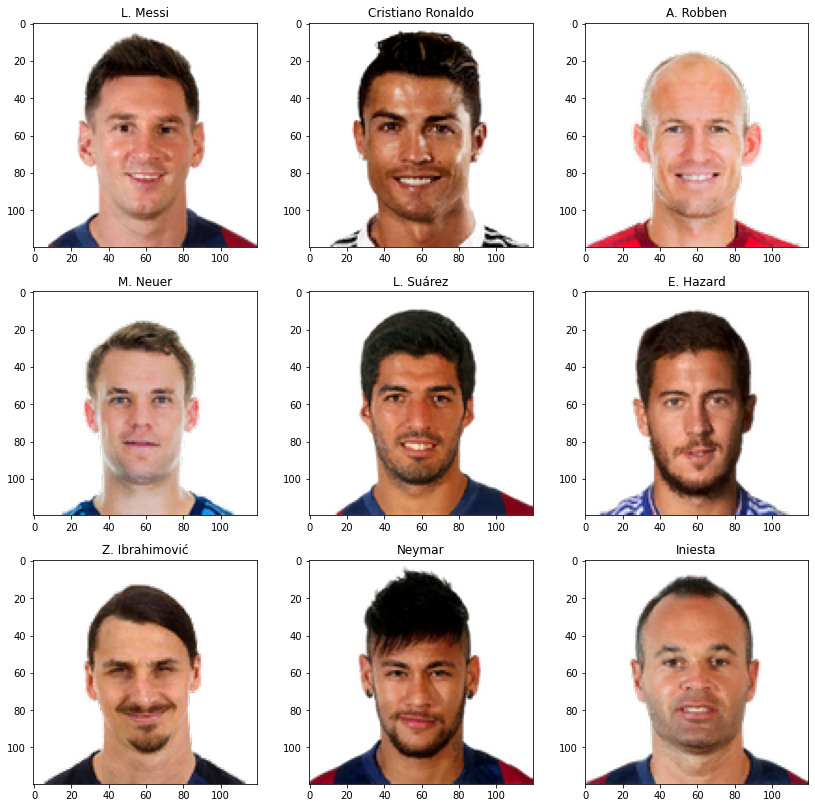

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))

for idx, path, name, axi in zip(df.index, df.img_path, df.short_name, ax.flat):
    
    if idx < 10:

        img = Image.open(path)
        axi.imshow(img)
        axi.set_title(name)    
    else:
        break
plt.show()

## Correções do Web Scrapping (já executado)

### Salvar Imagens

In [ ]:
for i, url in enumerate(df['img_url'].values):
    try:
        os.makedirs('./drive/MyDrive/Antropometria' + url[22:].split(os.path.basename(url))[0][:-1])
    except:
        pass
    img = Image.open(requests.get(url, stream=True).raw)
    img.save('./drive/MyDrive/Antropometria' + url[22:])    

In [ ]:
path = "./drive/MyDrive/Antropometria" #@param {type:"string"}
df['img_path'] = path + df['img_url'].str[22:]

### Checar jogadores sem imagens

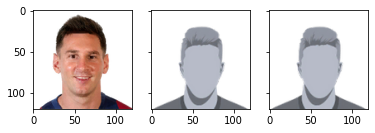

In [ ]:
samples = [Image.open(df.img_path[i]) for i in [0, 18230, 24522]]
fig, axs = plt.subplots(1,3, sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axs[i].imshow(sample)

In [ ]:
def check(img_a, img_b):
    if ImageChops.difference(img_a, img_b).getbbox():
        return "Diferents"
    else:
        return "Equals"

print('Sample 1 - 2: {}'.format(check(samples[1],samples[2])))
print('-----------------------')
print('Sample 0 - 2: {}'.format(check(samples[0],samples[2]))) 

Sample 1 - 2: Equals
-----------------------
Sample 0 - 2: Diferents


In [ ]:
non_img = samples[1]
ignore_indices = []

for i, path in enumerate(df.img_path):

    if ImageChops.difference(Image.open(path), non_img).getbbox():
        ignore_indices.append(False)
    else:
        ignore_indices.append(True)
    if i % 100 == 99:
        pd.DataFrame(ignore_indices).to_csv('./drive/MyDrive/Antropometria/ignore_indices.csv')
        print(f'{i/len(df.img_path)}%', end='\r')

In [ ]:
df = pd.concat([df, pd.DataFrame(ignore_indices)], axis=1).rename(columns={0:'ignore'})

In [ ]:
df = df.loc[df['ignore'] == False]

## Análise dos dados

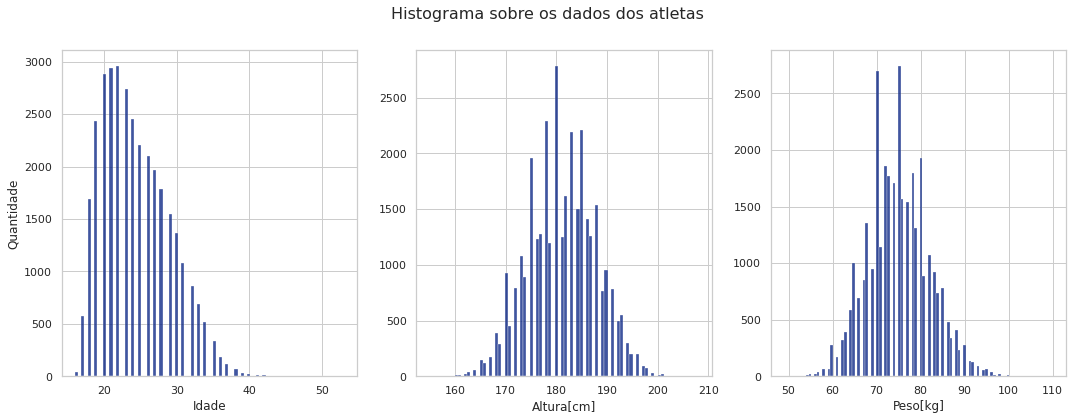

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Histograma sobre os dados dos atletas', fontsize=16)
sns.set_theme(style="whitegrid", palette="dark")

for i, data, xlabel, ylabel in zip(df.index, [df.age, df.height_cm, df.weight_kg], ['Idade', 'Altura[cm]', 'Peso[kg]'], ['Quantidade', '','']):
    sns.histplot(data,ax= axs[i])
    axs[i].set_xlabel(xlabel)
    axs[i].set_ylabel(ylabel)

## Marcação de referência dos rostos

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def aplicar_refs(df):

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("./drive/MyDrive/data/shape_predictor_68_face_landmarks.dat")
    amostras = {'imagens': [], 'previsao': []}

    for i in df.index:

        img = Image.open(df['img_path'][i])
        img_ = np.array(img.convert('L'))
        
        det  = detector(img_, 0)

        try:
            pred = predictor(img_, det[0])
            pred = face_utils.shape_to_np(pred)
        except:
            pred = None
        
        amostras['imagens'].append(img)
        amostras['previsao'].append(pred)

        if i % 24 == 23:
            print(f'\rProgresso {(i+1)/33624}%', end='')
            pd.DataFrame(amostras.values(), index=amostras.keys()).transpose().to_csv('./drive/MyDrive/Antropometria/soccer_predictions.csv')

    return amostras


refs = aplicar_refs(df)
refs_df = pd.DataFrame(refs.values(), index=refs.keys()).transpose()
refs_df.to_csv('./drive/MyDrive/Antropometria/soccer_predictions.csv')

In [ ]:
xs_cols = [str(i) for i in range(137) if i % 2 == 1]
ys_cols = [str(i) for i in range(1,137) if i % 2 == 0]

In [ ]:
df = df.reset_index(drop=True)

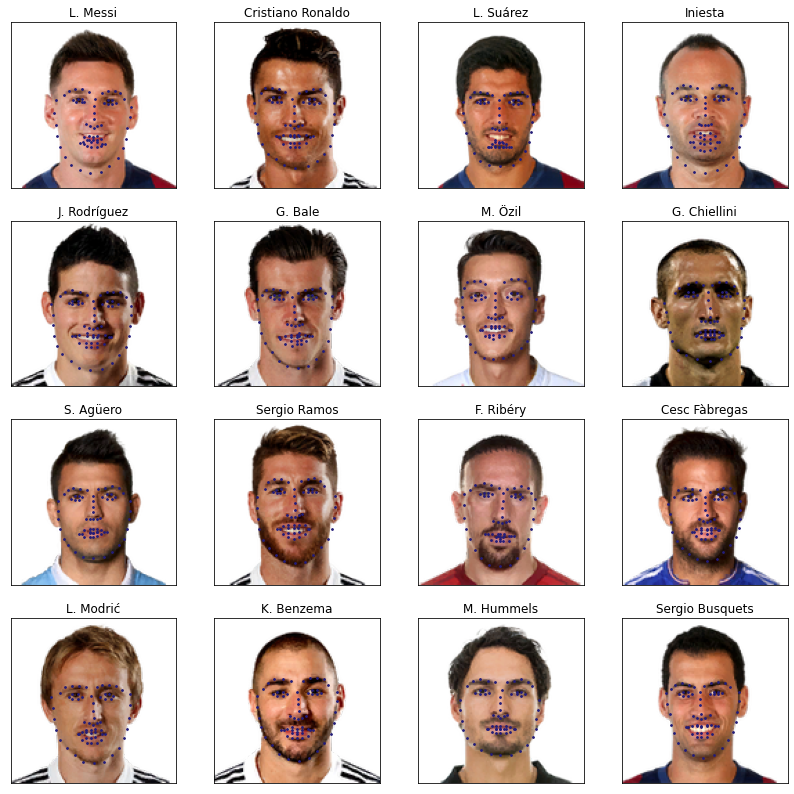

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(14,14))

for idx, axi in zip(df.index, ax.flat):
    
    if idx < 16:

        x, y = df[xs_cols].iloc[idx].values, df[ys_cols].iloc[idx].values
        img = Image.open(df.img_path.iloc[idx])

        axi.get_xaxis().set_visible(False)
        axi.get_yaxis().set_visible(False)

        axi.imshow(img)
        axi.scatter(x,y, s=3, c='#241d78')
        
        axi.set_title(df.short_name.iloc[idx])    
    else:
        break

plt.show()

In [ ]:
def angle_calculation(points_A, points_B, opt='deg'):
    angles = []

    for X, Y in points_A:
        row_angles = []
        for x,y in points_B:
            rad_angle = math.atan2(Y - y, X - x)
            deg_angle = math.degrees(rad_angle)
            if deg_angle < 0:
                deg_angle = 180 + deg_angle
            if opt == 'deg':
                row_angles.append(round(deg_angle,8))
            else:
                row_angles.append(round(rad_angle,8))
        angles.append(row_angles)

    return angles

def dists_calculation(points_A, points_B):
    matrix = []

    for X, Y in points_A:
        vector = []
        for x,y in points_B:
            dist = math.sqrt( (X - x)**2 + (Y -y)**2)
            vector.append(round(dist,8))
        matrix.append(vector)

    return matrix

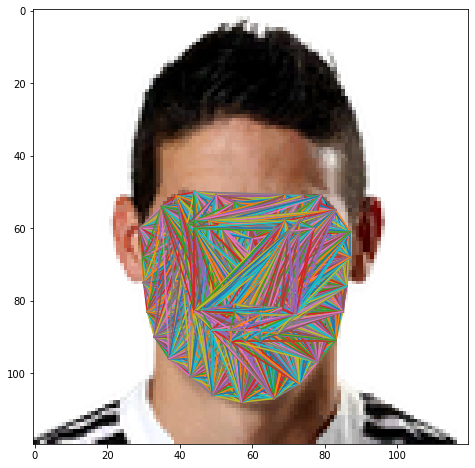

In [ ]:
for idx in df.index:
    if idx == 4:

        plt.figure(figsize=(8,8))
        img = Image.open(df['img_path'].iloc[idx])

        xs, ys = df[xs_cols].iloc[idx].values, df[ys_cols].iloc[idx].values
        points = np.array([point for point in zip(xs,ys)])
        
        points_distances = dists_calculation(points,points)
        points_angles    = angle_calculation(points,points,'rad')

        for i, (xA,yA) in enumerate(points):
            for j, (xB,yB) in enumerate(points):
                if j > i:
                    plt.plot([xA,xB],[yA,yB])
        
        plt.imshow(img)
        break

### Extrair distâncias e ângulos dos pontos

In [ ]:
dists, angs = [], []
for idx in df.index:
    xs, ys = df[xs_cols].iloc[idx].values, df[ys_cols].iloc[idx].values
    points = np.array([point for point in zip(xs,ys)])
    
    p_dists = dists_calculation(points,points)
    p_angls = angle_calculation(points,points,'deg')

    il1 = np.triu_indices(68,1)

    s_dists, s_angls = np.array(p_dists)[il1], np.array(p_angls)[il1]
    dists.append(s_dists)
    angs.append(s_angls)

    if idx % 24 == 23:
        print(f'\rProgress {((idx + 1)/len(df.index)) * 100:.4}%',end='')

Progress 99.92%

In [3]:
dists = np.loadtxt('/content/drive/MyDrive/Antropometria/dists.txt')

### Análise de componente Principal

In [ ]:
data = []
for dist,ang in zip(dists,angs):
    data.append(np.hstack([dist,ang]))

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
# prepare transform on dataset
pca.fit(dists,df['height_cm'])
# apply transform to dataset
transformed_data = pca.transform(dists)

## Aprendizado de Máquina

In [14]:
data = df.drop(['short_name','long_name','img_url','img_path','ignore'],axis=1).astype(int)
data = data[data.columns.tolist()[2:] + data.columns.tolist()[:2]]

In [ ]:
data.head(3)

,weight_kg,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,age,height_cm
0,72,32,56,31,65,32,74,33,82,35,...,66,88,62,86,58,86,55,85,28,170
1,80,28,58,29,65,30,73,31,80,34,...,69,83,61,87,57,87,54,87,30,185
2,85,32,57,32,65,33,72,34,80,36,...,65,90,60,86,58,86,55,85,28,182


In [25]:
X = data[['age','height_cm']]
y = data['weight_kg'].values

In [6]:
X = transformed_data
y = df['height_cm'].values

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X,y)
X = scaler.transform(X)

In [19]:
X.shape, y.shape

((21233, 2), (21233,))

In [20]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [ ]:
xgbModel = xgb.XGBRegressor(objective="reg:squarederror")

params = {
    "colsample_bytree": uniform(0.8, 0.1),
    "gamma": uniform(0, 0.9),
    "learning_rate": uniform(0.001, 0.3), 
    "max_depth": randint(2, 15),
    "n_estimators": randint(100, 500),
    "subsample": uniform(0.8, 0.2)
}

search = RandomizedSearchCV(xgbModel, param_distributions=params, random_state=42, n_iter=30, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

for i in range(1, 4):
        candidates = np.flatnonzero(search.cv_results_['rank_test_score'] == i)
        for candidate in candidates:
            print("\nModel with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  search.cv_results_['mean_test_score'][candidate],
                  search.cv_results_['std_test_score'][candidate]))
            print("Parameters: {0}".format(search.cv_results_['params'][candidate]))
best_param = search.cv_results_['params'][1]

In [28]:
best_param = {'colsample_bytree': 0.81480869299534, 'gamma': 0.8979664365440477, 'learning_rate': 0.0810343042825855, 'max_depth': 3, 'n_estimators': 229, 'subsample': 0.8822074026636463}

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

y_preds = []

for train_idx, val_idx in kfold.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    xgbModel = xgb.XGBRegressor(**best_param, \
                                random_state=21,objective="reg:squarederror")
    
    xgbModel.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_val,y_val)], \
                                eval_metric=["mae","rmse"])

    y_pred = xgbModel.predict(X_val)

[0]	validation_0-mae:68.4479	validation_0-rmse:68.7773
Multiple eval metrics have been passed: 'validation_0-rmse' will be used for early stopping.

Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-mae:62.906	validation_0-rmse:63.2366
[2]	validation_0-mae:57.8122	validation_0-rmse:58.1442
[3]	validation_0-mae:53.1326	validation_0-rmse:53.4907
[4]	validation_0-mae:48.8347	validation_0-rmse:49.1961
[5]	validation_0-mae:44.8809	validation_0-rmse:45.249
[6]	validation_0-mae:41.2482	validation_0-rmse:41.6455
[7]	validation_0-mae:37.9125	validation_0-rmse:38.3413
[8]	validation_0-mae:34.8452	validation_0-rmse:35.2837
[9]	validation_0-mae:32.0278	validation_0-rmse:32.5014
[10]	validation_0-mae:29.4365	validation_0-rmse:29.9236
[11]	validation_0-mae:27.0537	validation_0-rmse:27.5801
[12]	validation_0-mae:24.8662	validation_0-rmse:25.4108
[13]	validation_0-mae:22.8553	validation_0-rmse:23.4435
[14]	validation_0-mae:21.0087	validation_0-rmse:21.62
[15]	validation_

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


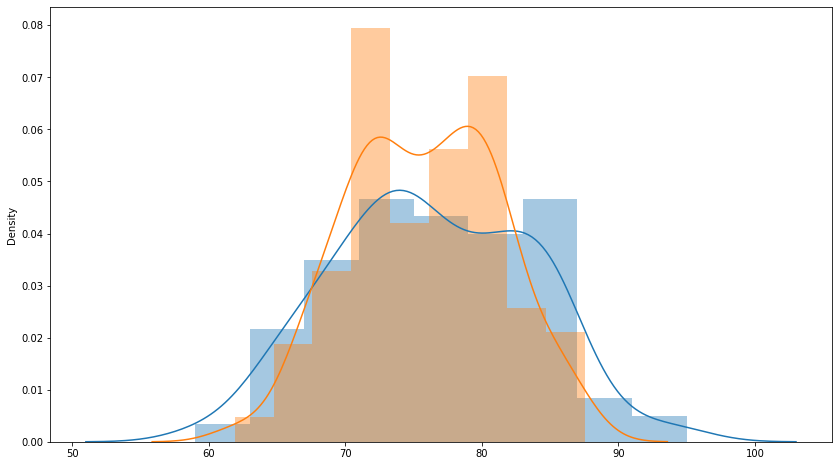

In [30]:
x = range(150)

fig = plt.figure(figsize=(14,8))
sns.distplot(y_val[:150])
sns.distplot(y_pred[:150])

In [31]:
results = pd.concat([pd.DataFrame(y_pred, columns=['Previsao']),pd.DataFrame(y_val, columns=['Real']).reset_index(drop=True)],axis=1)

In [32]:
results

,Previsao,Real
0,77.198235,75
1,71.354568,74
2,80.428802,79
3,81.133789,85
4,84.974884,85
...,...,...
4241,71.915825,74
4242,69.407753,70
4243,75.676155,70
4244,79.322357,84


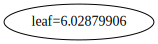

In [ ]:
xgb.to_graphviz(xgbModel)